# Overview

All scenario's notebooks have the same structure:

- [Description of the scenario](#description)
- [Analysis of the calibration step in the real world and obtain calibration values for SimGrid's execution](#calibration)
- [Analysis of the execution of the scenario and comparison with the predicted results obtained in SimGrid](#comparison)

# Initialization code

In [3]:
library(viridis)
library(ggplot2)
library(plotly)
library(plyr)
library(dplyr)
library(tidyr)
library(tikzDevice)
library(gridExtra)
library(zoo)
library(ggpointdensity)
library(hexbin)

getwd()
# modify default plots size
options(repr.plot.width=15, repr.plot.height=7)
#setwd("yourpathifnecessary")

[1] "/home/clem/Code/github.com/klementc/calvin-microbenchmarks/comparison"

<a id='description'></a>
# 1st scenario results

This file describes the steps used to perform the experiment, and provides visualizations of the results.

## Scenario

The scenario consists in 1 computing node. The datasource will send requests to it with various work amounts (loop iterations), the computing node once finishing the request sends the result to the Sink node, which does nothing but some logging.

The experiment lasts for 5 minutes and is repeated 4 times for each work amount (40*4=160 launches) to limit random effects.


Here are the parameters used:

```
----------------------------------------------------
PARAMETERS:
suffix: reprodscen1
Parallelization degree: 8
HostLogPath: /home/ccourageuxsudan/logs_expe/goLogs/reprod_scenario1_2021-04-09_09-08-08/
nbIters: start=1, end=80000001, iter=2000000
Samples: 4
Timestamp file: /go/src/app/timestamps/default5TimeStamps.csv
First core used: 0
----------------------------------------------------

```

## Reproduce

This scenario was launched on Grid'5000's paravance cluster.

Example of node reservation: `oarsub -p "cluster='paravance'" -l host=4,walltime=6 -I`

The experiment was launched using: `repoPath="/home/ccourageuxsudan/SGMicroservices/calvin-microbenchmarks/rabbitmqGo/" onG5K=1 run=1 scenario=1 bash launcherReproduce.s`

## Output

Output logs for this scenario can be found under:

- For the calibration step: `results_reprod/reprod_calib_2021-04-09_09-08-08/`
- For the execution: `results_reprod/reprod_scenario1_2021-04-09_09-08-08/`


## Synthetic Loads


We use 2 synthetic workloads to perform our experiments:

- Calibration workload: one request triggered every 3 seconds for 5 minutes (300 seconds)
- Execution workload: varying workload generated using LIMBO, with 3 spikes


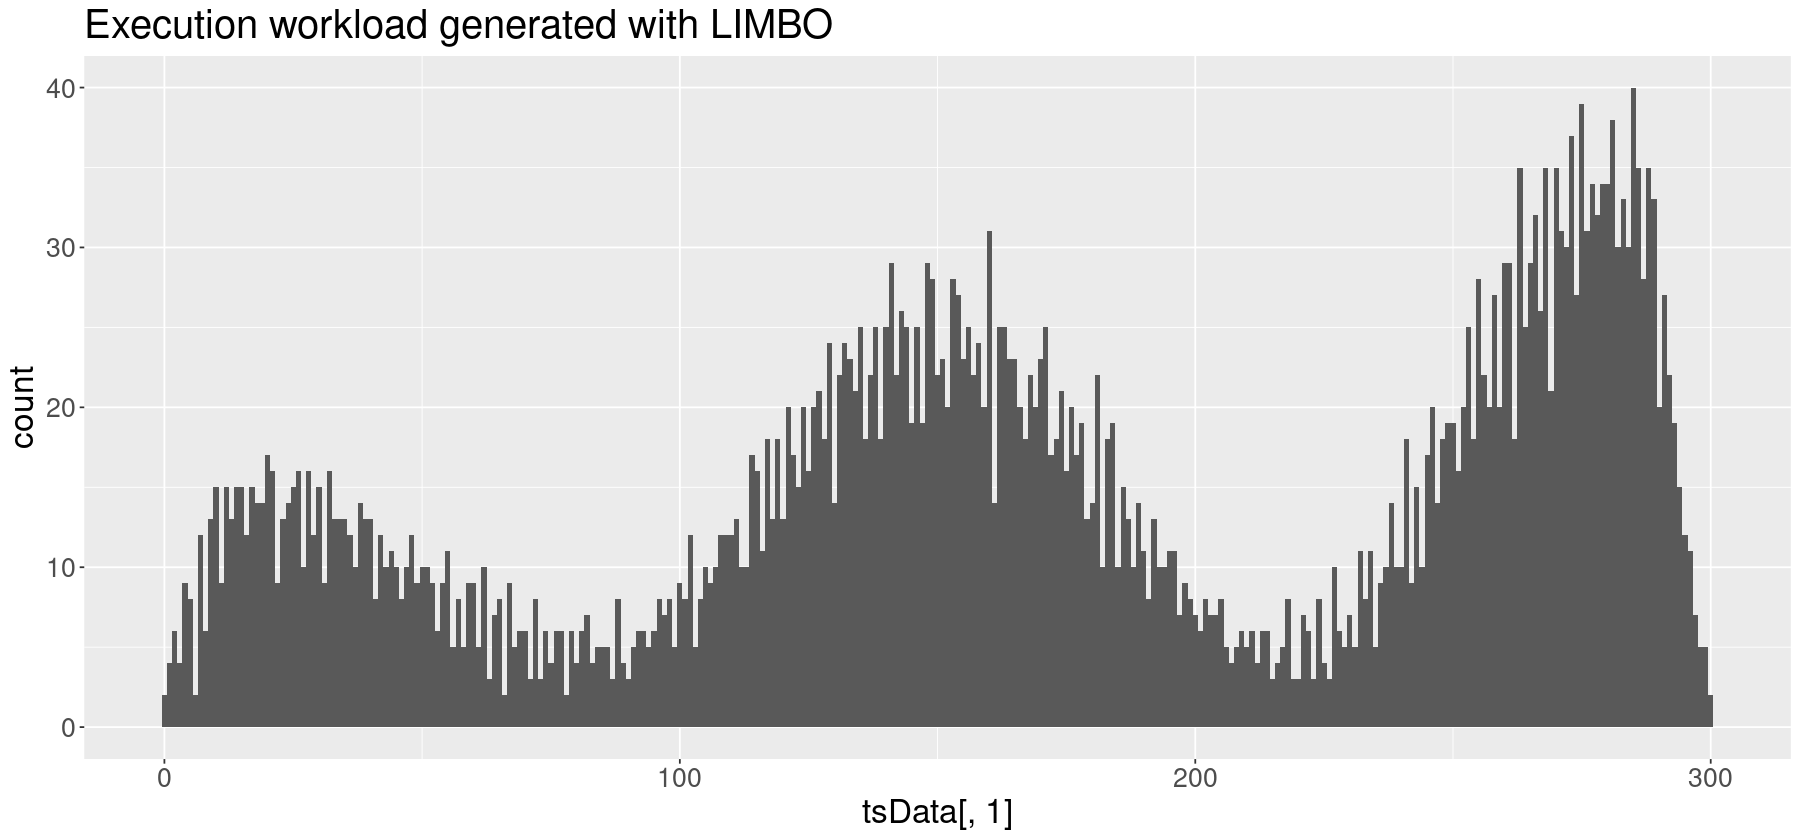

In [4]:
options(repr.plot.width=15, repr.plot.height=7)

tsData <- read.csv("./files/tsload.csv")

colnames(tsData) <- c("timestamp")

ggplot(tsData, aes(x=tsData[,1])) +
    geom_histogram(binwidth=1) +
    theme(text = element_text(size = 20)) + 
    ggtitle("Execution workload generated with LIMBO")

# Load Datasets

In [20]:
##### CALIBRATION
data_calibration <- as_tibble(read.csv("results_reprod/reprod_calib_2021-04-09_09-08-08/1_aggrResults_1-10000000-100000002_4.csv"))
summary(data_calibration)

# preprocess to obtain timestamps as seconds instead of microseconds
data_calibration$timestampSec <- as.numeric(as.character(data_calibration$timestamp)) / 1e9
data_calibration$computeDurSec <- as.numeric(as.character(data_calibration$computeDur)) / 1e9

data_calibration_sg <- as_tibble(read.csv("results_reprod/sg_calib/sg_cal_scenario1.csv"))
summary(data_calibration_sg)

###### LOAD EXECUTION
data_SG_load <- as_tibble(read.csv("results_reprod/sg_run/sg_load_scenario1.csv"))
data_load_RW <- as_tibble(read.csv("results_reprod/reprod_scenario1_2021-04-09_09-08-08/1_aggrResults_1-2000000-80000001_4.csv"))
data_load_RW$timestampSec <- as.numeric(as.character(data_load_RW$timestamp)) / 1e9
data_load_RW$computeDurSec <- as.numeric(as.character(data_load_RW$computeDur)) / 1e9



 serviceName            nbIter        timestamp          totDurInServ     
 Length:4400        Min.   :1e+00   Min.   :0.000e+00   Min.   :    1504  
 Class :character   1st Qu.:2e+07   1st Qu.:7.425e+10   1st Qu.: 7070123  
 Mode  :character   Median :5e+07   Median :1.485e+11   Median :16265301  
                    Mean   :5e+07   Mean   :1.485e+11   Mean   :17039889  
                    3rd Qu.:8e+07   3rd Qu.:2.228e+11   3rd Qu.:26217308  
                    Max.   :1e+08   Max.   :2.970e+11   Max.   :45793350  
   computeDur          parExec       totReqProcessed   scenario        
 Min.   :     251   Min.   :0.0000   Min.   : 0.00   Length:4400       
 1st Qu.: 7068324   1st Qu.:0.0000   1st Qu.:24.75   Class :character  
 Median :16262986   Median :1.0000   Median :49.50   Mode  :character  
 Mean   :17037464   Mean   :0.5305   Mean   :49.50                     
 3rd Qu.:26215322   3rd Qu.:1.0000   3rd Qu.:74.25                     
 Max.   :45788765   Max.   :1.0000   Max.  

       ts              qArr        instArr       startEx        endEx       
 Min.   :  4.00   Min.   :  4   Min.   :  4   Min.   :  4   Min.   :  4.00  
 1st Qu.: 76.03   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76   1st Qu.: 76.03  
 Median :151.02   Median :151   Median :151   Median :151   Median :151.02  
 Mean   :151.02   Mean   :151   Mean   :151   Mean   :151   Mean   :151.02  
 3rd Qu.:226.01   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226   3rd Qu.:226.01  
 Max.   :298.03   Max.   :298   Max.   :298   Max.   :298   Max.   :298.03  
     flops              serv          
 Min.   :  263000   Length:1089       
 1st Qu.: 6973000   Class :character  
 Median :17038000   Mode  :character  
 Mean   :17038000                     
 3rd Qu.:27103000                     
 Max.   :33813000                     

<a id='calibration'></a>
# Calibration Step

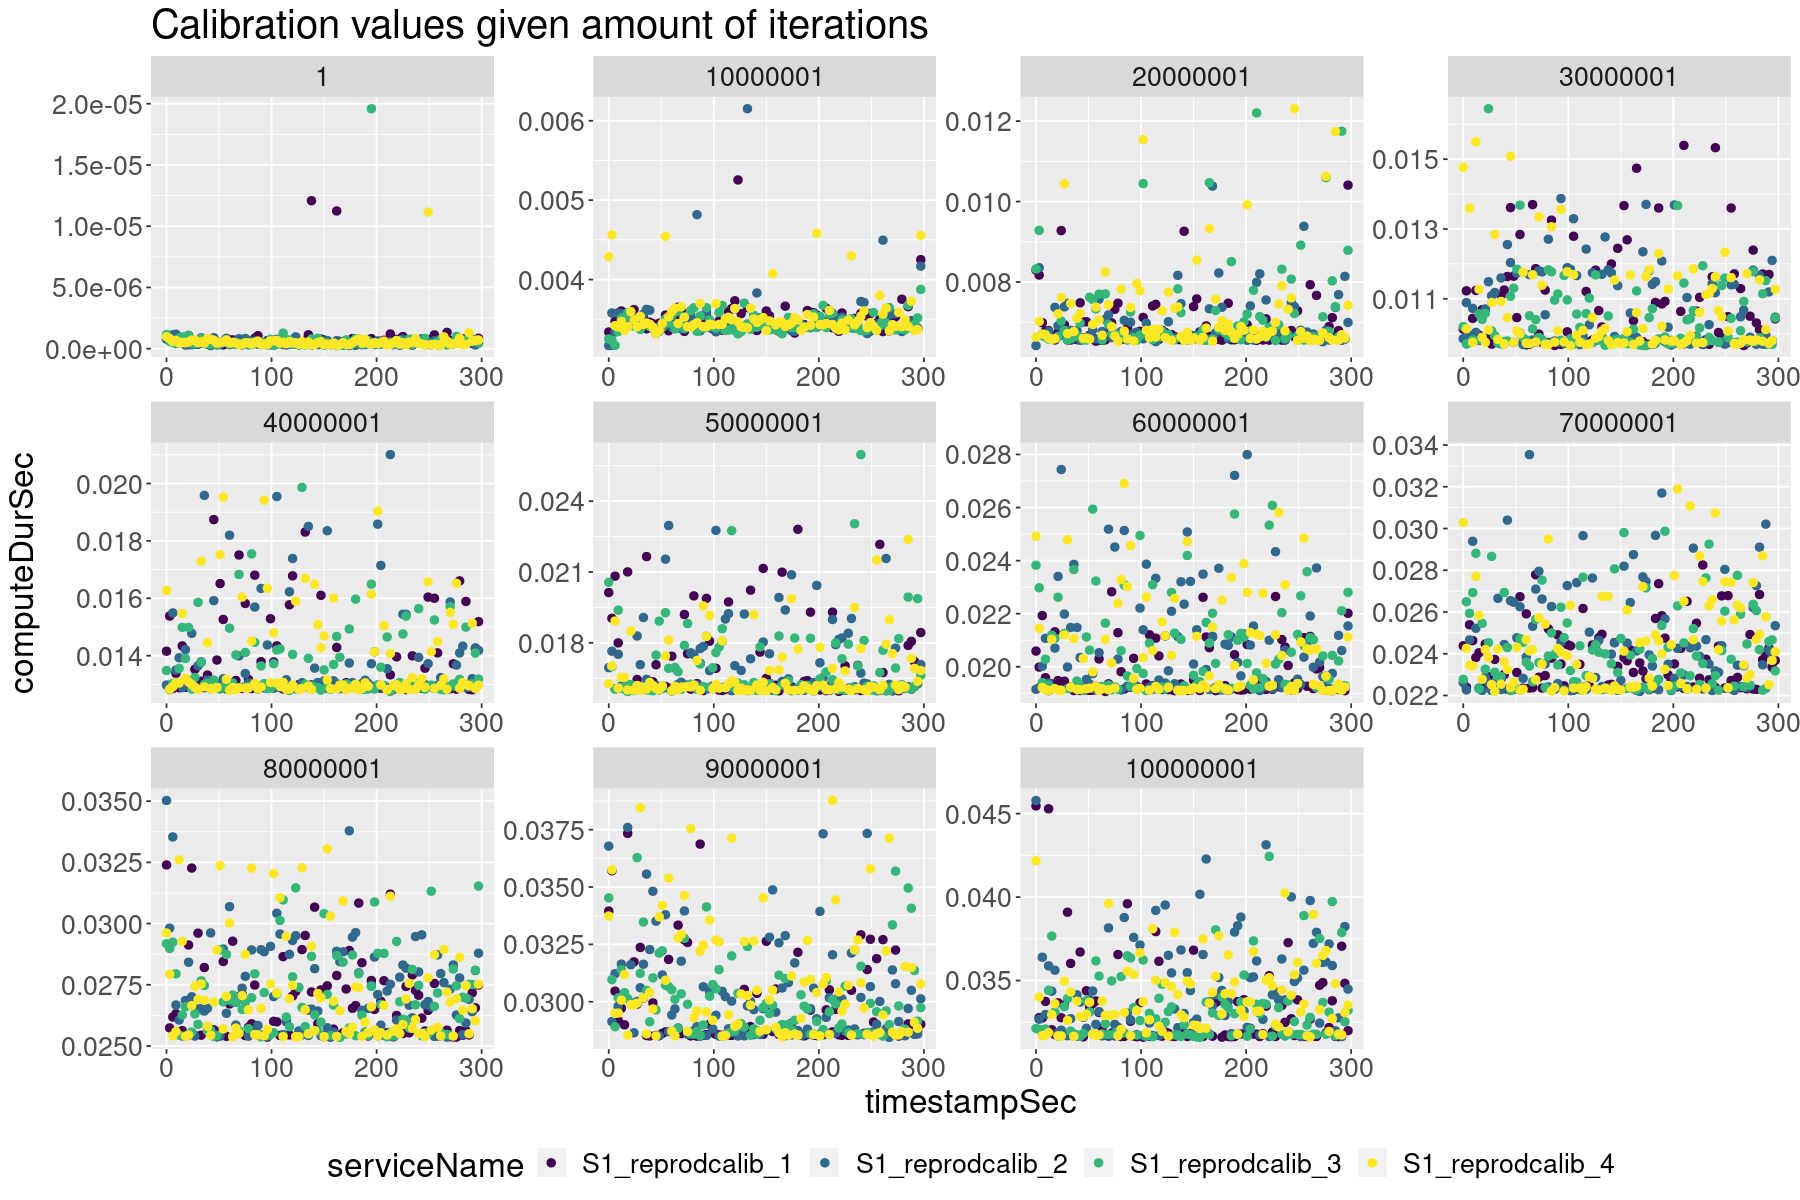

In [11]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data_calibration, aes(x=timestampSec, y=computeDurSec, colour=serviceName))+
    geom_point(size=2)+
    ggtitle("Calibration values given amount of iterations")+
    facet_wrap("nbIter", scales="free")+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) 

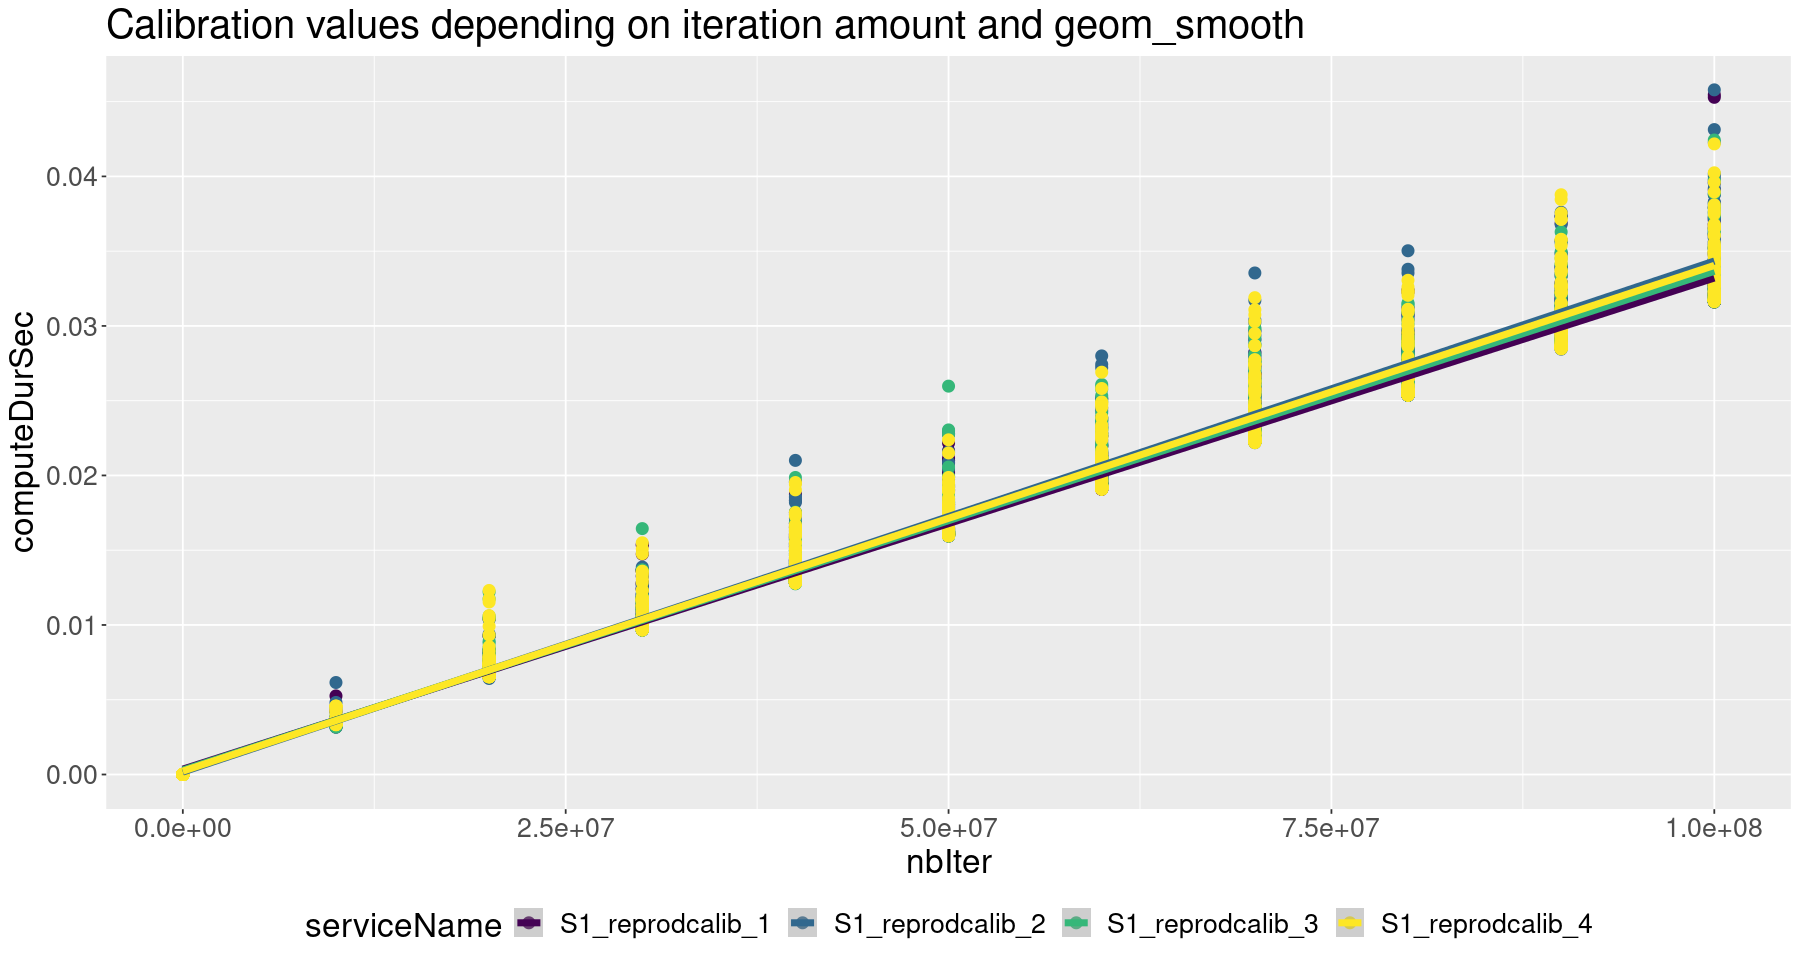

In [12]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data_calibration, aes(x=nbIter, y=computeDurSec, colour=serviceName))+
    geom_point(size=3)+
    theme( legend.position="bottom", text = element_text(size = 20)) + 
    scale_color_viridis(discrete = TRUE, option = "D")+
    scale_fill_viridis(discrete = TRUE) + 
    ggtitle("Calibration values depending on iteration amount and geom_smooth")+
    geom_smooth(formula = y ~ x, method='lm', size=2)

## Linear regression to obtain calibration values

Given the previous graph, we can clearly observe (as expected) a linear relationship between the amount of work of the compute node, and the duration to execute a request. Thus we can use a linear regression to estimate the duration of a request given an amount of work (as a number of iterations). This value will then be used to calibrate our SimGrid code.

In [13]:
calibrationRegression = lm(computeDurSec ~ nbIter, data=data_calibration)
summary(calibrationRegression)


Call:
lm(formula = computeDurSec ~ nbIter, data = data_calibration)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0022215 -0.0008961 -0.0002626  0.0003094  0.0119768 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.630e-04  4.552e-05   5.777 8.14e-09 ***
nbIter      3.355e-10  7.695e-13 436.004  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001614 on 4398 degrees of freedom
Multiple R-squared:  0.9774,	Adjusted R-squared:  0.9774 
F-statistic: 1.901e+05 on 1 and 4398 DF,  p-value: < 2.2e-16


The obtained equation is:
### ```dur = nbIter*3.355*10**(-10)+2.630*10**(-4)``` 

## Utility function to obtain duration from nbIter

In [14]:
nbIter_to_duration <- function(nbIter) {
  return (nbIter*3.355*10**(-10)+2.630*10**(-4))
}

# utilitary function
nbIter_to_duration_to_SG <- function(start, end, iter, fact=1) {
    for(i in seq(from=start, to=end, by=iter)){
        cat(paste(trunc(fact*nbIter_to_duration(i)*10^9)," "))
    }
}

# example
print(nbIter_to_duration(2.5*10**8))
print(nbIter_to_duration(5*10**8))
print(nbIter_to_duration(7.5*10**8))

[1] 0.084138
[1] 0.168013
[1] 0.251888


## Calibration comparison between real world data and SimGrid

In [15]:
start=1
end=100000002
iter=10000000

nbIter_to_duration_to_SG(start, end, iter)

263000  3618000  6973000  10328000  13683000  17038000  20393000  23748000  27103000  30458000  33813000  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_cal_scenario1.csv
for i in 263000  3618000  6973000  10328000  13683000  17038000  20393000  23748000  27103000  30458000  33813000 
do
    echo "Calibration for iterAmount=$i"
    scenario=1 parDeg=10 tsFile=../rabbitmqGo/timestamps/tsCal.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_cal_scenario1.csv
done
```

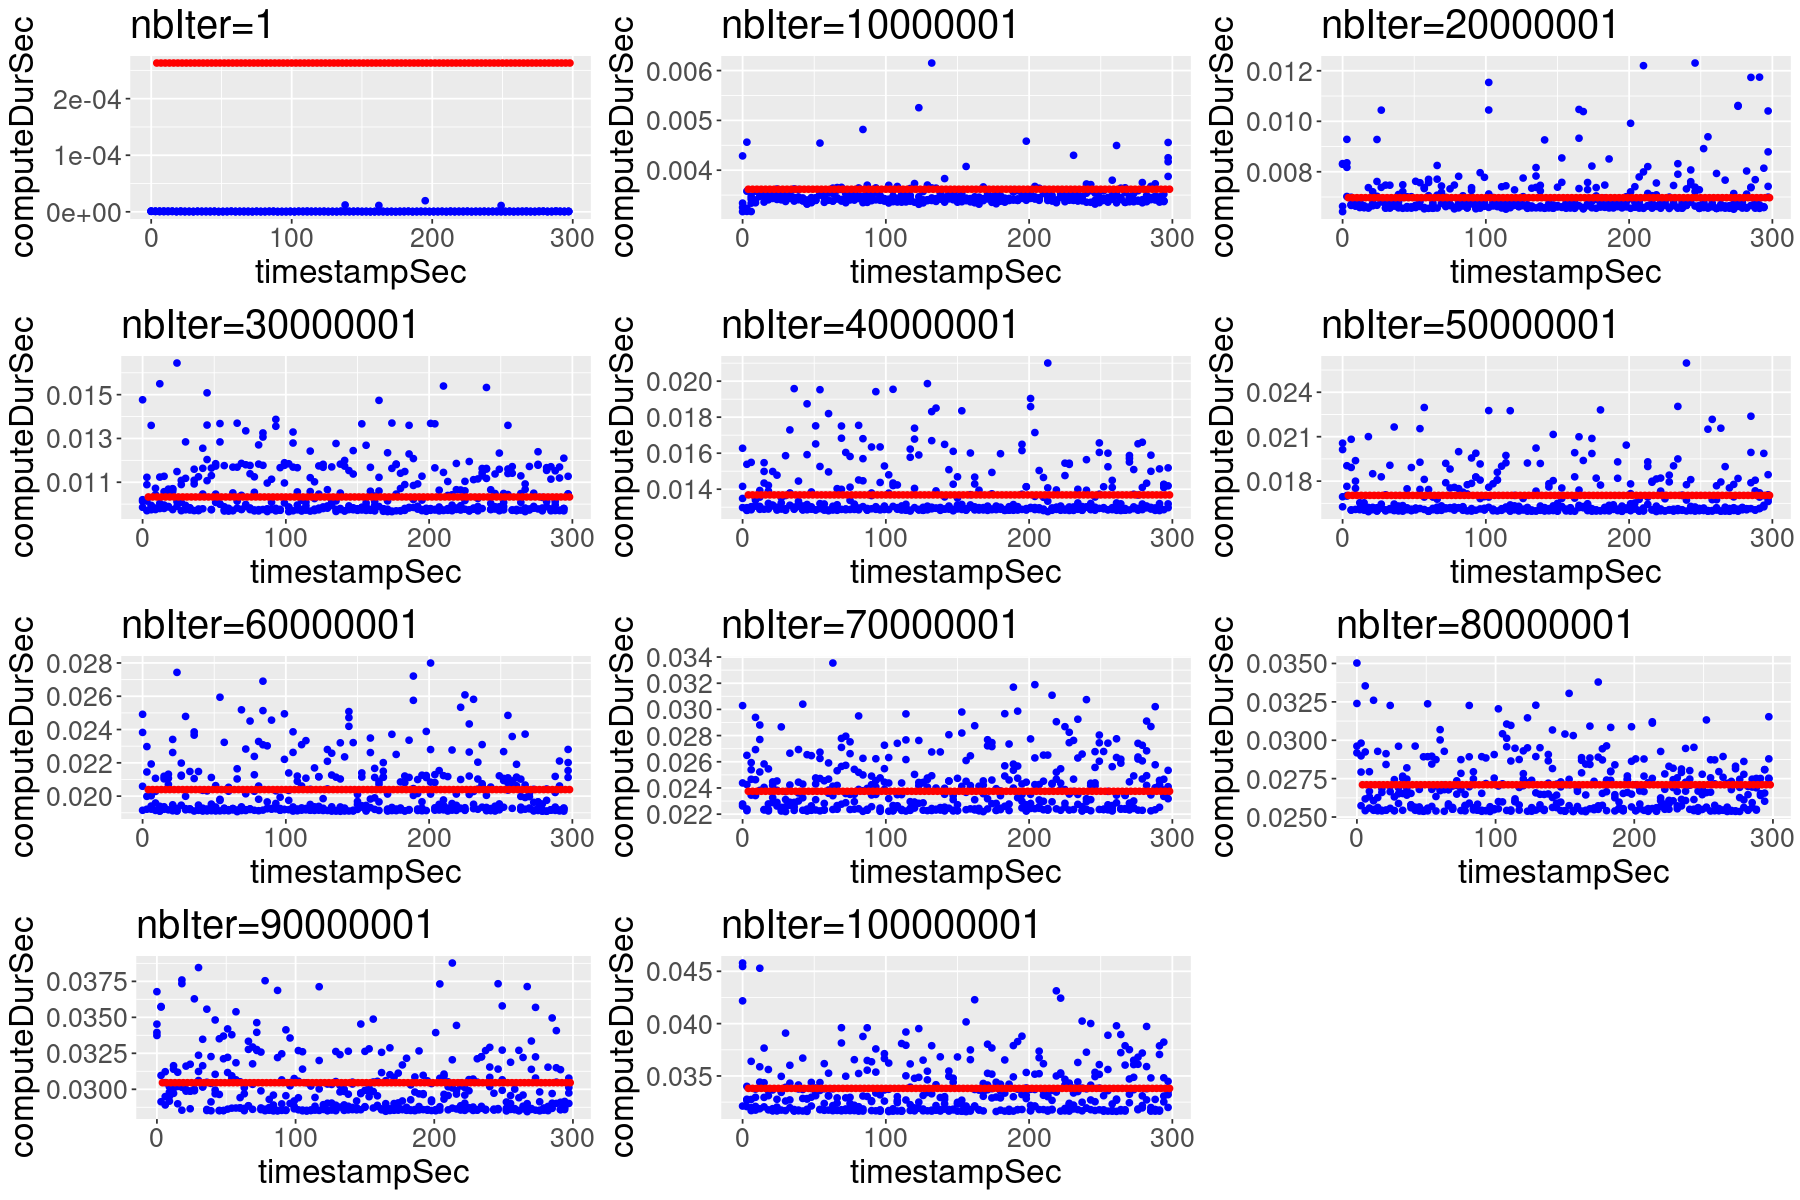

In [17]:
options(repr.plot.width=15, repr.plot.height=10)
P <- list()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red")+
        labs(title=sprintf("nbIter=%d",i))+
        theme(text = element_text(size = 20))+ 
        scale_color_viridis(discrete = TRUE, option = "D")+
        scale_fill_viridis(discrete = TRUE) 
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))

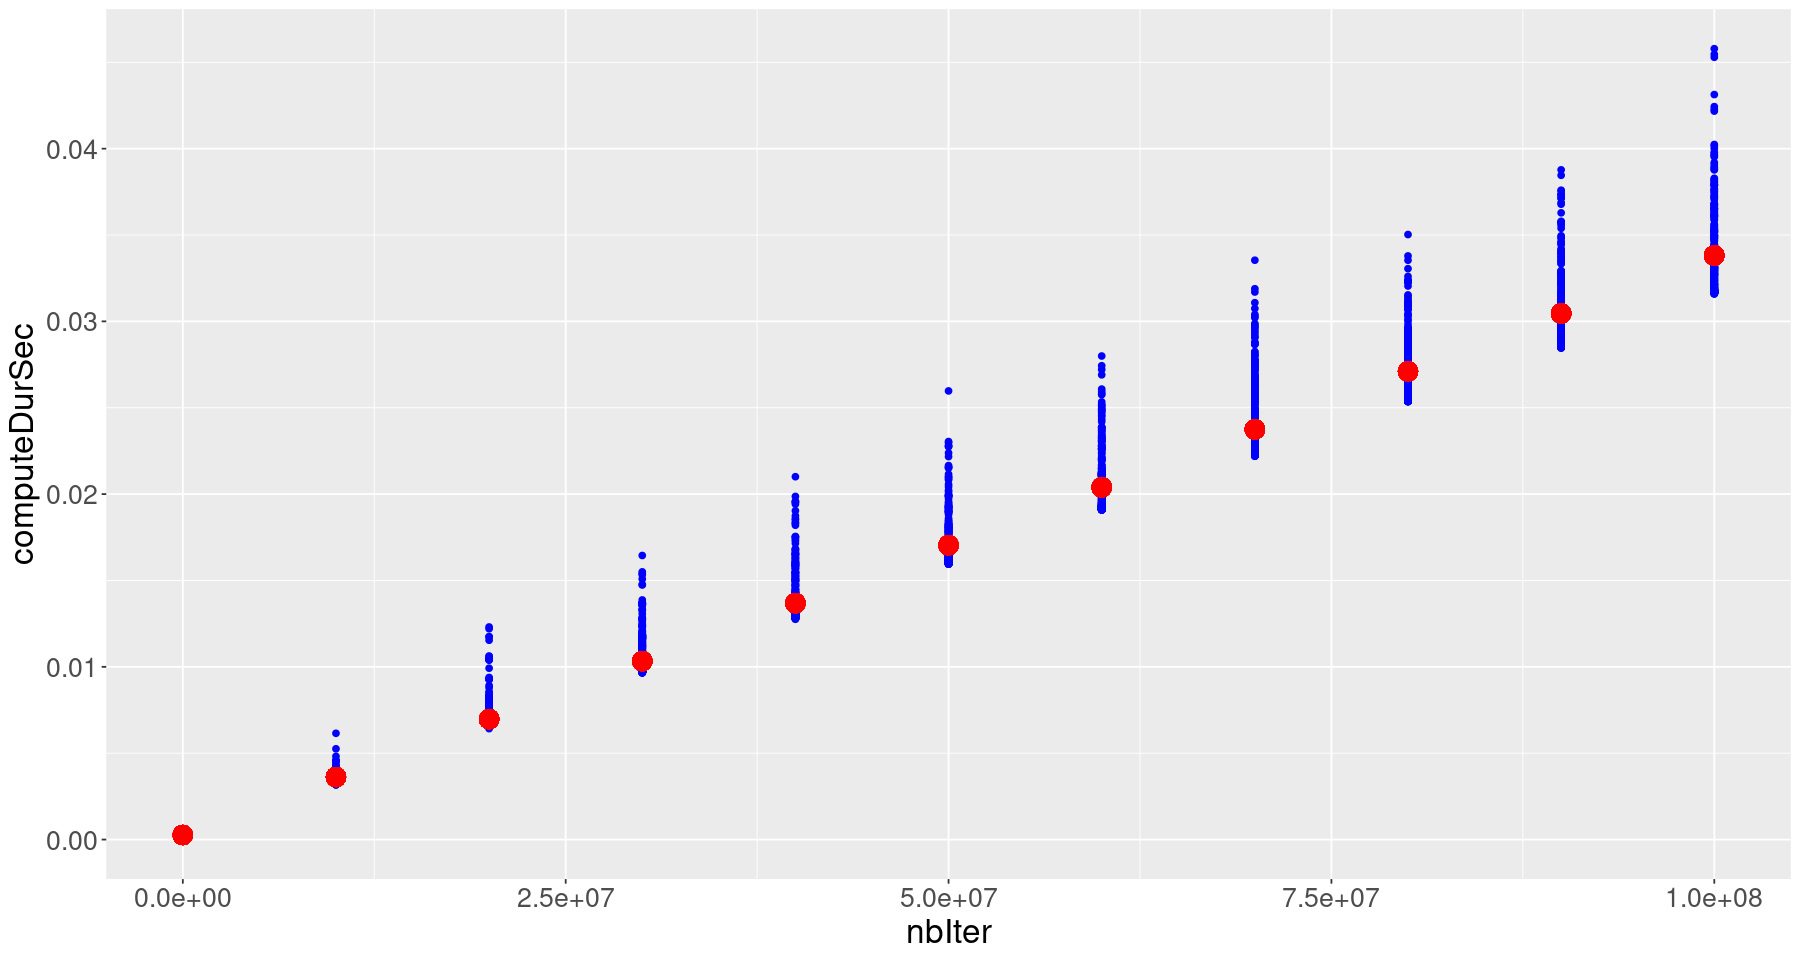

In [18]:

options(repr.plot.width=15, repr.plot.height=8)
P <- list()
g <- ggplot()
for(i in seq(from=1, to=100000002, by=10000000)){
    tmpsg <- subset(data_calibration_sg, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_calibration, nbIter == i)
    tmpsg$nb <- i

    g <- g +
        geom_point(data = tmpG5K, aes(x=nbIter, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=nb, y=endEx-startEx), color = "red", size=5)+
        theme(text = element_text(size = 20))
    P <- c(P, list(g))
    
}
g

<a id='comparison'></a>
# Execution comparison


In [19]:
# obtain flop amount for 1GF nodes in SimGrid

start=1
end=80000001
iter=2000000

nbIter_to_duration_to_SG(start, end, iter)

263000  934000  1605000  2276000  2947000  3618000  4289000  4960000  5631000  6302000  6973000  7644000  8315000  8986000  9657000  10328000  10999000  11670000  12341000  13012000  13683000  14354000  15025000  15696000  16367000  17038000  17709000  18380000  19051000  19722000  20393000  21064000  21735000  22406000  23077000  23748000  24419000  25090000  25761000  26432000  27103000  

SG command to launch benchmark:

```sh

echo "ts,qArr,instArr,startEx,endEx,flops,serv" > sg_load_scenario1.csv
for i in 263000  934000  1605000  2276000  2947000  3618000  4289000  4960000  5631000  6302000  6973000  7644000  8315000  8986000  9657000  10328000  10999000  11670000  12341000  13012000  13683000  14354000  15025000  15696000  16367000  17038000  17709000  18380000  19051000  19722000  20393000  21064000  21735000  22406000  23077000  23748000  24419000  25090000  25761000  26432000  27103000
do
    echo "Calibration for iterAmount=$i"
    scenario=1 parDeg=8 tsFile=default5TimeStamps.csv logDir=~/logs_expe/sgLogs/calibration start=$i end=$i incr=1 bash launch.sh
    tail -n+2 ~/logs_expe/sgLogs/calibration/results.csv >> sg_load_scenario1.csv
done
```

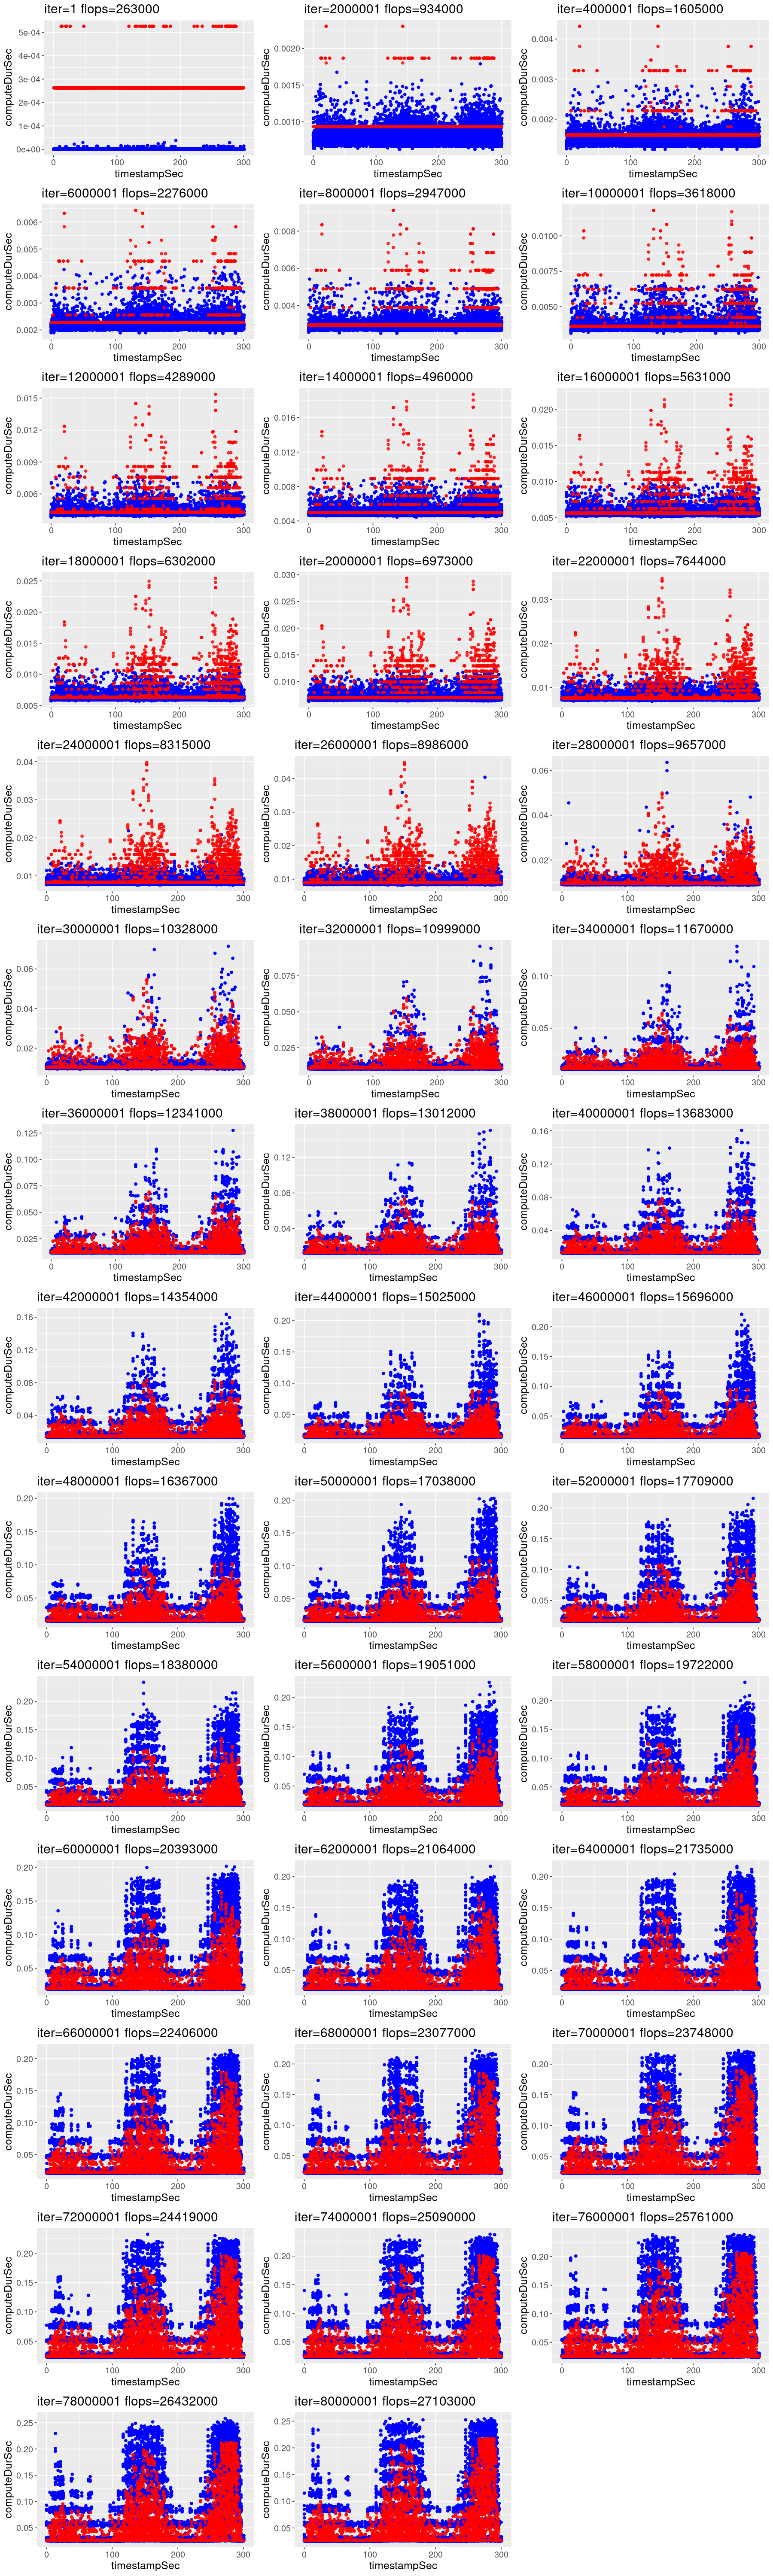

In [21]:

options(repr.plot.width=15, repr.plot.height=50)

P <- list()
for(i in seq(from=1, to=80000001, by=2000000)){
    tmpsg <- subset(data_SG_load, flops == trunc(nbIter_to_duration(i)*10^9))
    tmpG5K <- subset(data_load_RW, nbIter == i)
    g <- ggplot() +
        geom_point(data = tmpG5K, aes(x=timestampSec, y=computeDurSec), color="blue")+
        geom_point(data = tmpsg, aes(x=ts, y=endEx-startEx), color = "red",alpha = 0.8)+
        labs(title=sprintf("iter=%d flops=%d",i,median(tmpsg$flops)))+
        theme(text = element_text(size = 15))
    P <- c(P, list(g))
    
}
do.call(grid.arrange, c(P,ncol=3))
